# 9: Markov Chain Monte Carlo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %cd "C:/msys64/home/ecotner/statistical-rethinking/"
%cd "/home/ecotner/statistical-rethinking/"

/home/ecotner/statistical-rethinking


In [3]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.tensor as tt
import pyro
from pyro.distributions import Normal, Exponential
from pyro.infer.mcmc import NUTS, MCMC

# sys.path.insert(0, "C:/msys64/home/ecotner/statistical-rethinking/code")
sys.path.insert(0, "/home/ecotner/statistical-rethinking/code")
from models import RegressionBase
from utils import precis, sample_posterior
# torch.multiprocessing.set_start_method("forkserver", force=True)
torch.multiprocessing.set_sharing_strategy("file_system")

### Code 9.1
Simple simulation to reproduce the "Metropolis algorithm" (not the real one, the simplified one from the story about "King Markov" and his island kingdom).

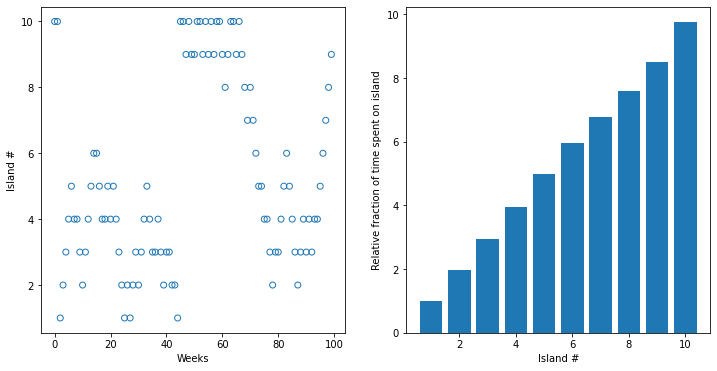

In [4]:
num_weeks = 1e5
positions = np.zeros(int(num_weeks))
current = 10
for i in range(int(num_weeks)):
    positions[i] = current
    proposal = current + np.random.choice((-1, 1))
    if proposal < 1: proposal = 10
    if proposal > 10: proposal = 1
    
    prob_move = proposal/current
    current = proposal if np.random.rand() < prob_move else current

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# Plot the markov chain samples
plt.sca(axes[0])
plt.scatter(np.arange(100), positions[:100], facecolor="none", edgecolor="C0")
plt.xlabel("Weeks")
plt.ylabel("Island #")
# Plot relative fraction of visitation frequency
plt.sca(axes[1])
val, count = np.unique(positions, return_counts=True)
plt.bar(val, height=count/count[0])
plt.xlabel("Island #")
plt.ylabel("Relative fraction of time spent on island")
plt.show()

### Code 9.2
Illustrate how probability mass in high-dimensional distributions is not necessarily located near the mode. The multidimensional standard normal, for example, has a differential probability mass of
$$
\begin{align}
dp &\propto d^nx\, \exp(-|\vec{x}|^2/2) \\
&\propto dr\, r^{n-1} \exp(-r^2/2)
\end{align}
$$
The radial probability density is proportional to $r^{n-1} \exp(-r^2/2)$, which we can see peaks further away from the mode of the distribution ($r=0$) the greater the dimension $n$.

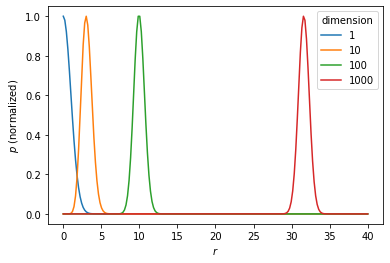

In [5]:
r = np.linspace(1e-3, 40, 200)
for n in (1, 10, 100, 1000):
    # calculate the log of the density first for numerical stability
    logp = (n-1)*np.log(r) - r**2/2
    p = np.exp(logp - logp.max())
    p /= p.max() # normalize to max
    plt.plot(r, p, label=n)
plt.xlabel("$r$")
plt.ylabel("$p$ (normalized)")
plt.legend(title="dimension")
plt.show()

We can sample from a random normal distribution too and show that the distribution of samples matches the theoretical estimate

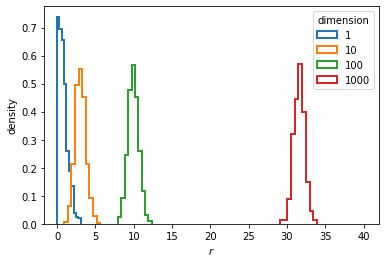

In [6]:
for n in (1, 10, 100, 1000):
    s = np.random.randn(n, 1000) # sample
    s = np.sqrt(np.square(s).sum(axis=0)) # dist from center
    plt.hist(s, density=True, histtype="step", linewidth=2, label=n)
plt.xlim(right=42)
plt.xlabel("$r$")
plt.ylabel("density")
plt.legend(title="dimension", loc="upper right")
plt.show()

### Code 9.3 - 9.?
Let's code up an HMC algorithm for fitting a simple Gaussian. We will need a couple pieces. First off is the "potential energy" function $U$, which is simply the negative log-likelihood of the model: $U(\theta) = -\ln L(\theta;X)$.

In [7]:
def U(q, a=0, b=1, k=0, d=1):
    muy = q[1]
    mux = q[2]
    _U = 

SyntaxError: invalid syntax (<ipython-input-7-7ba668b187c2>, line 4)

### Code 9.9 - 9.16
Now let's test out some HMC. I don't have access to the `ulam` function McElreath uses, so I'll just use `pyro`'s built-in NUTS kernel.

In [5]:
rugged_df = pd.read_csv("data/rugged.csv", sep=";")
rugged_df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [6]:
d = rugged_df.assign(log_gdp=np.log(rugged_df["rgdppc_2000"]))
dd = d[~d["log_gdp"].isna()].copy()
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()
dd["cid"] = dd["cont_africa"].astype(int)

Let's first fit the model using our Gaussian approximation

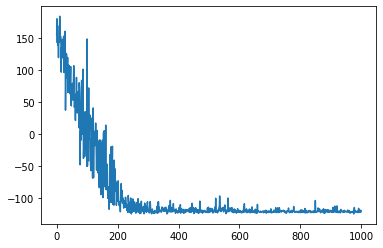

In [10]:
class M8_5(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_5 = M8_5(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
loss = m8_5.train(1000)
plt.plot(loss); plt.show()

In [11]:
samples = {"m8.5": sample_posterior(m8_5, 1000, ("a", "b", "sigma"))}
s = samples["m8.5"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,i]
    del s[var]
precis(s)

,mean,stddev,5.5%,94.5%
sigma,0.112459,0.00664639,0.102249,0.123161
a[0],1.05124,0.00977281,1.03555,1.06661
a[1],0.888144,0.0152302,0.862739,0.91122
b[0],-0.144781,0.0575049,-0.241357,-0.0535976
b[1],0.14488,0.122825,-0.0490211,0.34107


Now we can use NUTS to perform inference:

In [30]:
# Define the model; no guide needed
class M9_1:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
    
    def model(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
        
    def train(self, num_warmup, num_samples, num_chains=1):
        # apparently multiple chains does not work on windows; I should switch over to 
        # my ubuntu partition and try it out later
        kernel = NUTS(self.model, adapt_step_size=True, adapt_mass_matrix=True, jit_compile=True)
        self.engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
        self.engine.run()

In [32]:
m9_1 = M9_1(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
m9_1.train(1000, 1000, 1)

Sample: 100%|██████████| 2000/2000 [00:15, 127.46it/s, step size=6.87e-01, acc. prob=0.914]


In [13]:
# The secret to getting multiple chains to work is
# 1. the model must be a function, not an object. this causes pickling errors otherwise
# 2. do NOT set `torch.multiprocessing.set_start_method`; I found competing advice on
#    this but it seems not to work if this is called
# 3. do NOT use Windows. it can't handle the multiprocessing for some reason. I did this
#    on Ubuntu 18.04. I wonder if this works in WSL...

def format_data(df, categoricals=None):
    data = dict()
    if categoricals is None:
        categoricals = []
    for col in set(df.columns) - set(categoricals):
        data[col] = tt(df[col].values).double()
    for col in categoricals:
        data[col] = tt(df[col].values).long()
    return data

def model_m9_1(data, training=False):
    a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(0))
    b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(0))
    sigma = pyro.sample("sigma", Exponential(1.))
    A = data["cid"]
    mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
    if training:
        pyro.sample("log_gdp_std", Normal(mu, sigma), obs=data["log_gdp_std"])
    else:
        return pyro.sample("log_gdp_std", Normal(mu, sigma))

def train_nuts(model, data, num_warmup, num_samples, num_chains=1):
    kernel = NUTS(model, adapt_step_size=False, adapt_mass_matrix=True, jit_compile=True)
    engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
    engine.run(data, training=True)
    return engine

In [8]:
data = format_data(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
m9_1 = train_nuts(model_m9_1, data, 1000, 1000, 3) # I should have 4 cpu's, but pyro only recognizes 3...

In [12]:
samples["m9.1"] = {k: v.numpy() for k, v in m9_1.get_samples().items()}
s = samples["m9.1"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,i]
    del s[var]
precis(s)

,mean,stddev,5.5%,94.5%
sigma,0.111614,0.00592456,0.102533,0.121492
a[0],1.05041,0.0103462,1.03344,1.06681
a[1],0.886628,0.0155988,0.861155,0.912216
b[0],-0.141955,0.0551025,-0.229032,-0.0529563
b[1],0.129537,0.0746682,0.0105614,0.25075


I ran the above with a single chain (i.e. chain of samples), but you can run multiple chains in parallel. It is actually more efficient if you have multiple cores. (I know in tensorflow probability, you can use your GPU to sample, and this lets you do thousands of chains in parallel with no performance hit! Don't think this is available in pytorch unfortunately).

## Code 9.17 - 9.19
Let's analyze the results of this first HMC trial.

The pyro MCMC class tries to copy Stan as much as possible, so there are some convenience utilities that allow you to easily analyze the inference at a glance that are available in both:

In [13]:
m9_1.summary(prob=0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.05      0.01      1.05      1.03      1.07   2304.12      1.00
      a[1]      0.89      0.02      0.89      0.86      0.91   1590.81      1.00
      b[0]     -0.14      0.06     -0.14     -0.24     -0.06   1881.52      1.00
      b[1]      0.13      0.07      0.13      0.01      0.25   1344.38      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1342.34      1.00

Number of divergences: 0


We can see that even though we drew 1000 _actual_ samples, there are over 1000 _effective_ samples! This is because NUTS is so good, that the sampler can produce sequential samples that are better than uncorrelated (i.e. the autocorrelation between samples is actually negative).

Let's visualize the correlation of the samples

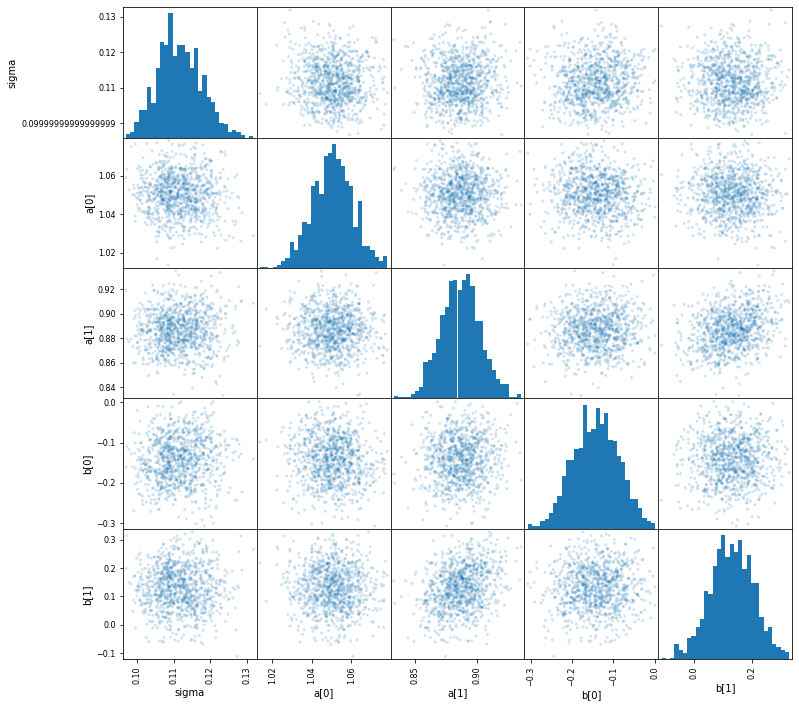

In [15]:
x = pd.DataFrame(s)
pd.plotting.scatter_matrix(x, hist_kwds={"bins": 30}, alpha=0.2, figsize=(12, 12))
plt.show()

Now let's visualize the Markov chain in sequential order. We want to check the chain for stationarity (no trend), mixing (rapid exploration of the full posterior - no slow drifting), and convergence (multiple chains stick around the same area)

In [5]:
def traceplot(s, num_chains):
    fig, axes = plt.subplots(nrows=len(s), figsize=(12, len(s)*num_chains))
    for (k, v), ax in zip(s.items(), axes):
        plt.sca(ax)
        for c in range(num_chains):
            plt.plot(v[c], linewidth=0.5)
        plt.ylabel(k)
    plt.xlabel("Sample index")
    return fig

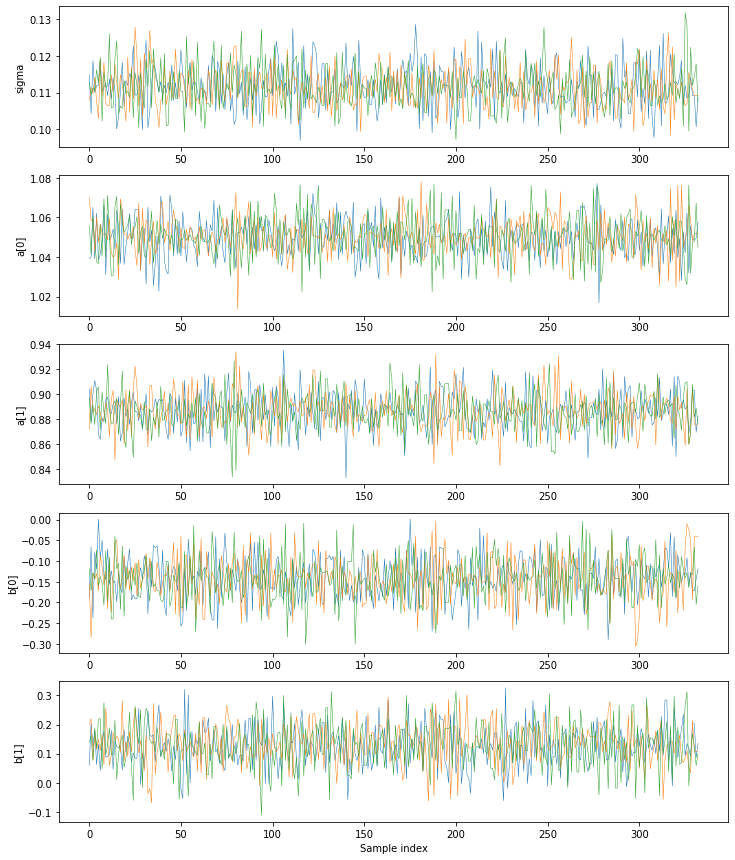

In [81]:
s = {k: v.numpy() for k, v in m9_1.get_samples(group_by_chain=True).items()}
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,:,i]
    del s[var]
traceplot(s, 3)
plt.show()

This looks pretty good, I guess. All the chains seem to converge on the same area of parameter space, and there doesn't seem to be any drifting or non-stationarity.

We will also visualize the convergence with a "trace rank plot" - you take all the samples from a single parameter, rank them from highest to lowest, then create an individual histogram of the ranks within each chain. There should be no correlation.

In [6]:
def trankplot(s, num_chains):
    fig, axes = plt.subplots(nrows=len(s), figsize=(12, len(s)*num_chains))
    ranks = {k: np.argsort(v, axis=None).reshape(v.shape) for k, v in s.items()}
    num_samples = 1
    for p in list(s.values())[0].shape:
        num_samples *= p
    bins = np.linspace(0, num_samples, 30)
    for i, (ax, (k, v)) in enumerate(zip(axes, ranks.items())):
        for c in range(num_chains):
            ax.hist(v[c], bins=bins, histtype="step", linewidth=2, alpha=0.5)
        ax.set_xlim(left=0, right=num_samples)
        ax.set_yticks([])
        ax.set_ylabel(k)
    plt.xlabel("sample rank")
    return fig

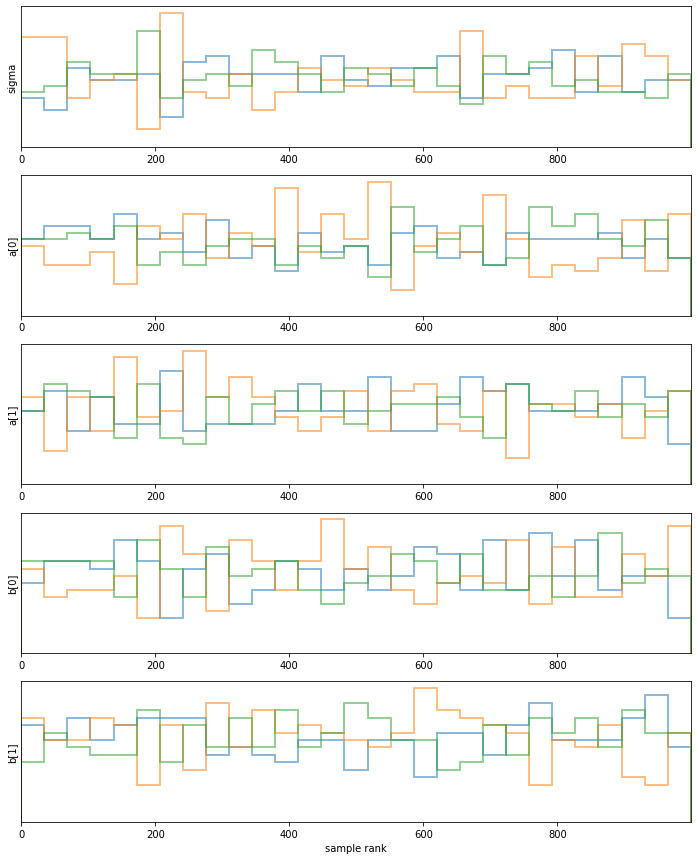

In [82]:
trankplot(s, 3)
plt.show()

### Code 9.20 - 9.22
Now that we know how to build these diagnostic tools, let's see what they look like when things go wrong with our HMC inference.

In [5]:
data = {"y": tt([-1., 1.])}

def model_m9_2(data, training=False):
    a = pyro.sample("a", Normal(0., 1000.))
    sigma = pyro.sample("sigma", Exponential(0.0001))
    mu = a
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_2 = train_nuts(model_m9_2, data, 1000, 1000, 2)

Ok, seems alright... the acceptance probability looks pretty low though. What about $n_{eff}$ and $\hat{R}$?

In [6]:
m9_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      9.90    303.90     -1.02   -611.23    383.04    141.22      1.00
     sigma    593.94   1028.02    234.84     13.85   1492.38      6.42      1.13

Number of divergences: 771


Wow, something is really wrong. $n_{eff}$ is super small, the std for the parameters is HUGE... I would expect it to be $O(1)$. Let's take a look at our diagnostic plots:

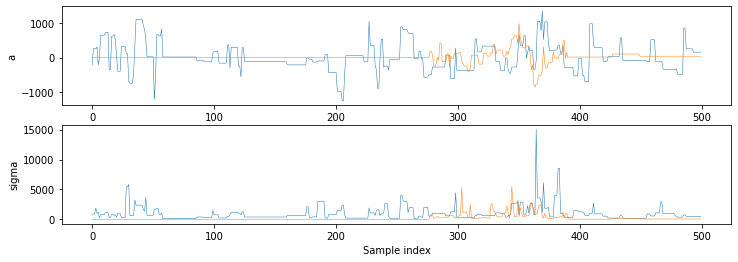

In [23]:
s = {k: v.numpy() for k, v in m9_2.get_samples(group_by_chain=True).items()}
traceplot(s, 2)
plt.show()

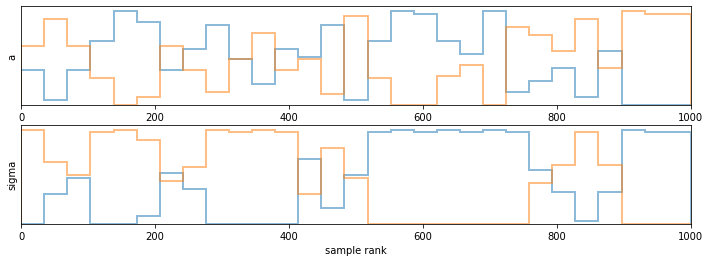

In [24]:
trankplot(s, 2)
plt.show()

These look very different from what we got before. In the trace plot, the chains bounce around wildly from point to point, never settling or converging properly. There is a good deal of autocorrelation as well. In the rank plot, the distribution of ranks highly nonuniform. There are massive gaps in the support for either chain.

How do we fix this? Well if we take a look at the priors we specified for `m9_2`, they are clearly ridiculous. Our data, $[-1, 1]$ has a mean of 0 and a standard deviation of O(1). The uncertainty on $a$'s prior is 1000 times larger! And the value of $\sigma$ makes no sense either; why is $a$ so uncertain, but the $\sigma$ is not? Let's specify more sensible priors.

In [18]:
data = {"y": tt([-1., 1.])}

def model_m9_3(data, training=False):
    a = pyro.sample("a", Normal(1., 10.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_3 = train_nuts(model_m9_3, data, 1000, 1000, 2)

In [19]:
m9_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.08      1.25      0.06     -1.93      1.93    519.23      1.00
     sigma      1.60      0.87      1.38      0.49      2.76    580.70      1.01

Number of divergences: 50


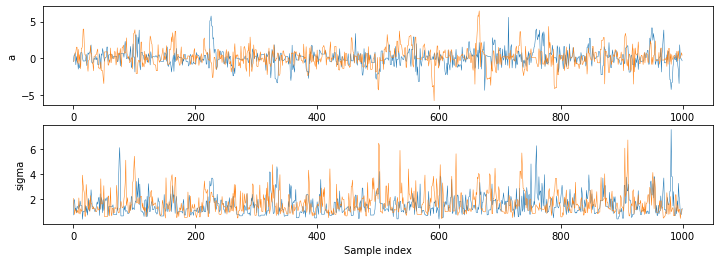

In [20]:
traceplot(m9_3.get_samples(group_by_chain=True), 2)
plt.show()

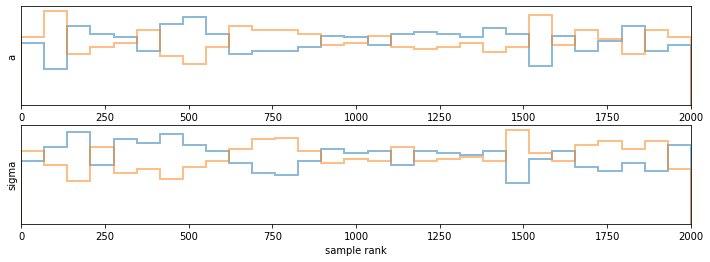

In [21]:
trankplot(m9_3.get_samples(group_by_chain=True), 2)
plt.show()

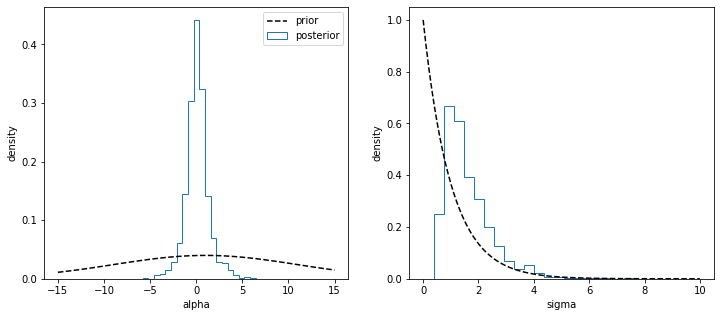

In [33]:
s = {k: v.numpy() for k, v in m9_3.get_samples().items()}
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
# alpha
plt.sca(axes[0])
x = torch.linspace(-15, 15)
plt.plot(x, Normal(1., 10.).log_prob(x).exp(), color="black", linestyle="--", label="prior")
plt.hist(s["a"], bins=20, histtype="step", density=True, label="posterior")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("density")
# sigma
plt.sca(axes[1])
x = torch.linspace(0, 10)
plt.plot(x, Exponential(1.).log_prob(x).exp(), color="black", linestyle="--", label="prior")
plt.hist(s["sigma"], bins=20, histtype="step", density=True, label="posterior")
plt.xlabel("sigma")
plt.ylabel("density")
plt.show()

### Code 9.23
There can also be problems with HMC when parameters are non-identifiable (though this problem is by no means unique to HMC). For example, if we define a model like
$$
y_i \sim \text{Normal}(\mu, \sigma) \\
\mu = \alpha_1 + \alpha_2 \\
\sigma \sim \text{Exp}(1)
$$
our choice of prior for the $\alpha_i$ will influence the convergence of our model. On a fundamental level, this model is misspecified, because we could reparametrize $\alpha_2 = -\alpha_1 + \mu$ and just sample from $\mu$ directly (i.e. we really only need one parameter, not two).

In [37]:
data = {"y": torch.randn((100,))}

def model_m9_4(data, training=False):
    a1 = pyro.sample("a1", Normal(0., 1000.))
    a2 = pyro.sample("a2", Normal(0., 1000.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a1 + a2
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_4 = train_nuts(model_m9_4, data, 1000, 1000, 2)

In [38]:
m9_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1     13.83     38.07     25.73    -54.19     61.53      1.61      3.52
        a2    -13.76     38.07    -25.75    -61.51     54.28      1.61      3.52
     sigma      0.86      0.06      0.86      0.76      0.96   1293.29      1.00

Number of divergences: 0


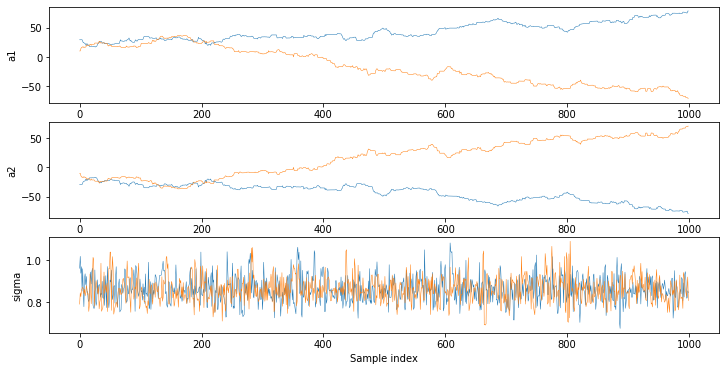

In [45]:
traceplot(m9_4.get_samples(group_by_chain=True), 2)
plt.show()

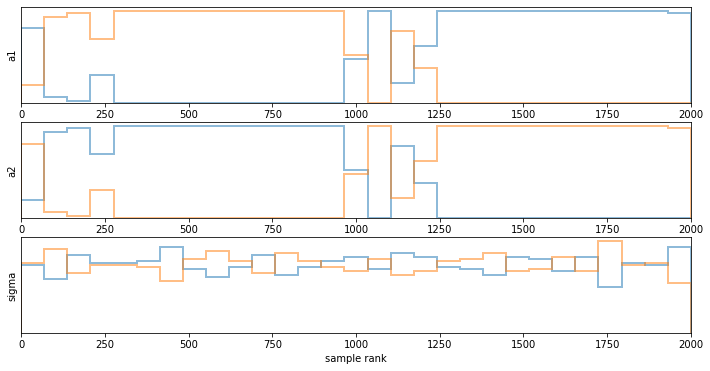

In [40]:
trankplot(m9_4.get_samples(group_by_chain=True), 2)
plt.show()

This looks really bad. Let's try some regularizing priors.

In [41]:
def model_m9_5(data, training=False):
    a1 = pyro.sample("a1", Normal(0., 10.))
    a2 = pyro.sample("a2", Normal(0., 10.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a1 + a2
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_5 = train_nuts(model_m9_5, data, 1000, 1000, 2)

In [42]:
m9_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1      2.36      6.89      1.81     -6.82     15.37     15.25      1.27
        a2     -2.28      6.89     -1.77    -15.27      6.90     15.24      1.27
     sigma      0.86      0.06      0.86      0.76      0.96   1381.85      1.00

Number of divergences: 0


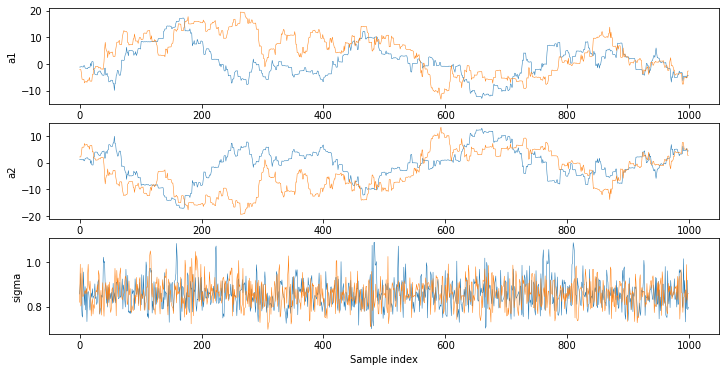

In [43]:
traceplot(m9_5.get_samples(group_by_chain=True), 2)
plt.show()

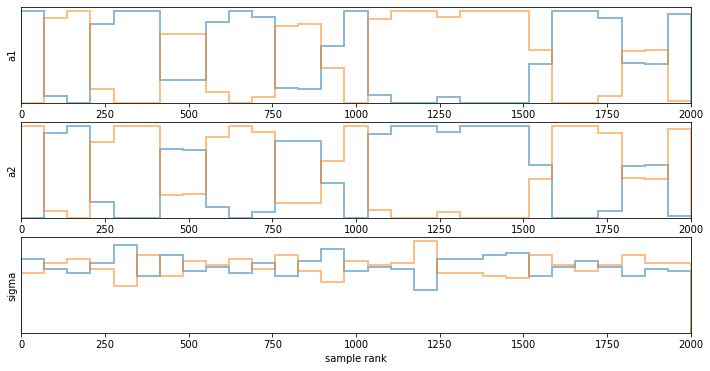

In [44]:
trankplot(m9_5.get_samples(group_by_chain=True), 2)
plt.show()

That looks a little better... but there are still problems with mixing in the `a1/a2` parameters. Let's just eliminate them entirely

In [46]:
def model_m9_6(data, training=False):
    # sqrt(2) = 1.41, and var(a1 + a2) = var(a1) + var(a2) for independent normals
    mu = pyro.sample("mu", Normal(0., 14.1))
    sigma = pyro.sample("sigma", Exponential(1.))
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_6 = train_nuts(model_m9_6, data, 1000, 1000, 2)

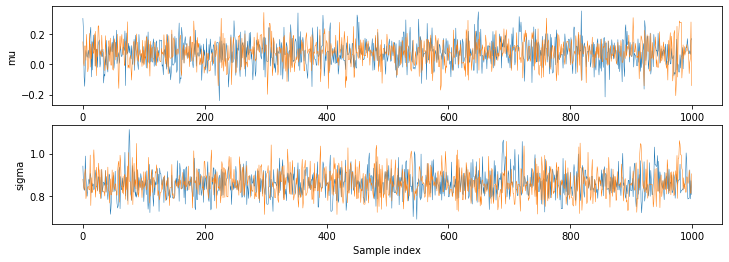

In [47]:
traceplot(m9_6.get_samples(group_by_chain=True), 2)
plt.show()

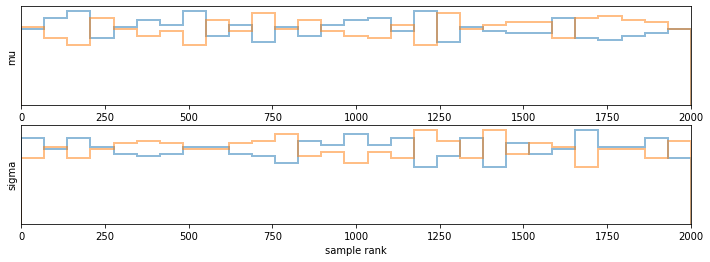

In [48]:
trankplot(m9_6.get_samples(group_by_chain=True), 2)
plt.show()

That ran so much faster, and the chains look a lot healthier!